Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training Time: 45.75 seconds
Best Tweedie Params: {'power': 1.7, 'alpha': 0.01}
Single Tweedie Regressor Performance with Uncertainty
RMSE = 251.70
MAE = 92.56
R-squared = -0.001
Training Time: 45.75 seconds
   Actual  Predicted  Lower CI (95%)  Upper CI (95%)
0     0.0  41.138110       28.567097       53.709122
1    90.0  52.080292       37.935883       66.224701
2     0.0  81.306693       63.633654       98.979732
3     0.0  85.449402       67.331721      103.567083
4     0.0  86.925910       68.652369      105.199451
Prediction Time (including conformal intervals): 0.02 seconds


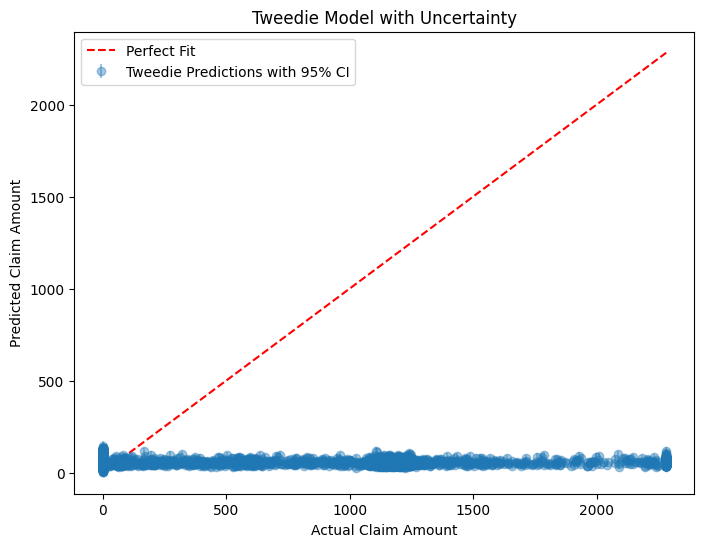

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import TweedieRegressor
from scipy.stats import norm
import time  # Import time module for measuring training time

##########################################
# STEP A: LOAD & CLEAN DATA
##########################################
df1 = pd.read_csv("/content/df_train_part1_20250212.csv")
df1.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)
df2 = pd.read_csv("/content/df_train_part2_20250212.csv")
df2.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)
df = pd.concat([df1, df2], axis=0)

# Capping extreme ClaimAmount at 99.5th percentile
cap_value = df["ClaimAmount"].quantile(0.995)
df["ClaimAmount"] = np.where(df["ClaimAmount"] > cap_value, cap_value, df["ClaimAmount"])

# Remove 'Exposure' from features, but keep it as sample weight
exposure = df["Exposure"].values
y = df["ClaimAmount"].values

# Features
num_features = ["CarAge", "DriverAge", "Density"]
cat_features = ["Brand", "Gas", "Region", "Power"]
all_features = num_features + cat_features

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Train/test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Train/test sets
X_train = train_df[all_features].copy()
y_train = train_df["ClaimAmount"].values
w_train = train_df["Exposure"].values  # sample weight

X_test = test_df[all_features].copy()
y_test = test_df["ClaimAmount"].values

##########################################
# STEP B: FEATURE ENGINEERING
##########################################
num_pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False)
)

cat_pipeline = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

##########################################
# STEP C: TWEEDIE REGRESSION WITH UNCERTAINTY
##########################################
model = TweedieRegressor(
    power=1.5,
    link="log",
    max_iter=2000,
    tol=1e-4
)

# Hyperparameter search
param_dist = {
    "power": [1.1, 1.3, 1.5, 1.7, 1.9],
    "alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
}

def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    scoring=make_scorer(rmse_scorer, greater_is_better=False),
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Measure training time
start_time = time.time()
search.fit(X_train_trans, y_train, sample_weight=w_train)
end_time = time.time()

training_time = end_time - start_time  # Time in seconds
print(f"Training Time: {training_time:.2f} seconds")
best_model = search.best_estimator_
print("Best Tweedie Params:", search.best_params_)

##########################################
# STEP D: PREDICTIONS WITH UNCERTAINTY
##########################################
start_time = time.time()  # Start the timer
y_pred = best_model.predict(X_test_trans)

# Compute standard error (approximation)
y_pred_std = np.sqrt(y_pred)

# Confidence intervals (95% CI)
z_score = norm.ppf(0.975)  # 1.96 for 95% confidence
lower_bound = y_pred - z_score * y_pred_std
upper_bound = y_pred + z_score * y_pred_std

##########################################
# STEP E: EVALUATION
##########################################
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(np.abs(y_test - y_pred))
r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))

print("Single Tweedie Regressor Performance with Uncertainty")
print(f"RMSE = {rmse:.2f}")
print(f"MAE = {mae:.2f}")
print(f"R-squared = {r2:.3f}")
print(f"Training Time: {training_time:.2f} seconds")  # Print training time again with evaluation

# Display prediction intervals
df_results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Lower CI (95%)": lower_bound,
    "Upper CI (95%)": upper_bound
})

print(df_results.head())
end_time = time.time()  # End the timer
training_time = end_time - start_time
print(f"Prediction Time (including conformal intervals): {training_time:.2f} seconds")
##########################################
# STEP F: VISUALIZATION
##########################################
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, y_pred, yerr=(upper_bound - lower_bound) / 2, fmt='o', alpha=0.4, label="Tweedie Predictions with 95% CI")
plt.plot([0, max(y_test)], [0, max(y_test)], color="red", linestyle="dashed", label="Perfect Fit")
plt.xlabel("Actual Claim Amount")
plt.ylabel("Predicted Claim Amount")
plt.title("Tweedie Model with Uncertainty")
plt.legend()
plt.show()

In [ ]:
# STEP 1: Load holdout dataset
X_holdout = pd.read_csv("X_holdout_20250212.csv")

# Ensure feature consistency
X_holdout_trans = preprocessor.transform(X_holdout)  # Use the trained preprocessor

# STEP 2: Predict Pure Premium
pure_premium_pred = best_model.predict(X_holdout_trans)

# STEP 3: Round predictions to 2 decimal places
X_holdout["PurePremium"] = np.round(pure_premium_pred, 2)

# STEP 4: Save the updated dataset with predictions
X_holdout.to_csv("X_holdout_with_PurePremium.csv", index=False)

print("Updated holdout dataset saved as X_holdout_with_PurePremium.csv")


Updated holdout dataset saved as X_holdout_with_PurePremium.csv


Fitting 3 folds for each of 10 candidates, totalling 30 fits

=== Tweedie Regressor Model Summary ===
Best Hyperparameters: {'power': 1.7, 'alpha': 0.01}
Training Time: 44.18 seconds
Model Type: TweedieRegressor (Generalized Linear Model)
Link Function: log
Number of Features: 40
Intercept: 4.0605
Sample Coefficients (first 5):
  Feature 0: -0.0836
  Feature 1: -0.0701
  Feature 2: 0.3608
  Feature 3: -0.0010
  Feature 4: -0.0423
Total Number of Coefficients: 40

Single Tweedie Regressor Performance with Uncertainty
RMSE = 251.70
MAE = 92.56
R-squared = -0.001
Training Time: 44.18 seconds
   Actual  Predicted  Lower CI (95%)  Upper CI (95%)
0     0.0  41.138110       28.567097       53.709122
1    90.0  52.080292       37.935883       66.224701
2     0.0  81.306693       63.633654       98.979732
3     0.0  85.449402       67.331721      103.567083
4     0.0  86.925910       68.652369      105.199451
Prediction Time (including conformal intervals): 0.01 seconds


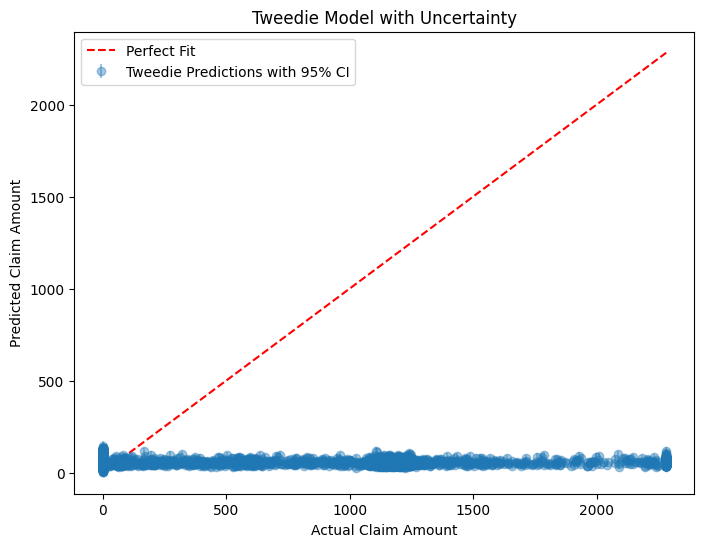

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import TweedieRegressor
from scipy.stats import norm
import time

##########################################
# STEP A: LOAD & CLEAN DATA
##########################################
df1 = pd.read_csv("/content/df_train_part1_20250212.csv")
df1.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)
df2 = pd.read_csv("/content/df_train_part2_20250212.csv")
df2.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)
df = pd.concat([df1, df2], axis=0)

# Capping extreme ClaimAmount at 99.5th percentile
cap_value = df["ClaimAmount"].quantile(0.995)
df["ClaimAmount"] = np.where(df["ClaimAmount"] > cap_value, cap_value, df["ClaimAmount"])

# Remove 'Exposure' from features, but keep it as sample weight
exposure = df["Exposure"].values
y = df["ClaimAmount"].values

# Features
num_features = ["CarAge", "DriverAge", "Density"]
cat_features = ["Brand", "Gas", "Region", "Power"]
all_features = num_features + cat_features

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Train/test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Train/test sets
X_train = train_df[all_features].copy()
y_train = train_df["ClaimAmount"].values


X_test = test_df[all_features].copy()
y_test = test_df["ClaimAmount"].values

w_train = train_df["Exposure"].values  # sample weight

##########################################
# STEP B: FEATURE ENGINEERING
##########################################
num_pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False)
)

cat_pipeline = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

##########################################
# STEP C: TWEEDIE REGRESSION WITH UNCERTAINTY
##########################################
model = TweedieRegressor(
    power=1.5,
    link="log",
    max_iter=2000,
    tol=1e-4
)

# Hyperparameter search
param_dist = {
    "power": [1.1, 1.3, 1.5, 1.7, 1.9],
    "alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
}

def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    scoring=make_scorer(rmse_scorer, greater_is_better=False),
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Measure training time
start_time = time.time()
search.fit(X_train_trans, y_train, sample_weight=w_train)
end_time = time.time()

training_time = end_time - start_time  # Time in seconds
best_model = search.best_estimator_

# --- Model Summary ---
print("\n=== Tweedie Regressor Model Summary ===")
print(f"Best Hyperparameters: {search.best_params_}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Model Type: TweedieRegressor (Generalized Linear Model)")
print(f"Link Function: {best_model.link}")
print(f"Number of Features: {X_train_trans.shape[1]}")
print(f"Intercept: {best_model.intercept_:.4f}")
print("Sample Coefficients (first 5):")
for i, coef in enumerate(best_model.coef_[:5]):  # Show first 5 coefficients
    print(f"  Feature {i}: {coef:.4f}")
print(f"Total Number of Coefficients: {len(best_model.coef_)}")

##########################################
# STEP D: PREDICTIONS WITH UNCERTAINTY
##########################################
start_time = time.time()  # Start the timer
y_pred = best_model.predict(X_test_trans)

# Compute standard error (approximation)
y_pred_std = np.sqrt(y_pred)

# Confidence intervals (95% CI)
z_score = norm.ppf(0.975)  # 1.96 for 95% confidence
lower_bound = y_pred - z_score * y_pred_std
upper_bound = y_pred + z_score * y_pred_std

##########################################
# STEP E: EVALUATION
##########################################
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(np.abs(y_test - y_pred))
r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))

print("\nSingle Tweedie Regressor Performance with Uncertainty")
print(f"RMSE = {rmse:.2f}")
print(f"MAE = {mae:.2f}")
print(f"R-squared = {r2:.3f}")
print(f"Training Time: {training_time:.2f} seconds")

# Display prediction intervals
df_results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Lower CI (95%)": lower_bound,
    "Upper CI (95%)": upper_bound
})

print(df_results.head())
end_time = time.time()  # End the timer
prediction_time = end_time - start_time
print(f"Prediction Time (including conformal intervals): {prediction_time:.2f} seconds")

##########################################
# STEP F: VISUALIZATION
##########################################
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, y_pred, yerr=(upper_bound - lower_bound) / 2, fmt='o', alpha=0.4, label="Tweedie Predictions with 95% CI")
plt.plot([0, max(y_test)], [0, max(y_test)], color="red", linestyle="dashed", label="Perfect Fit")
plt.xlabel("Actual Claim Amount")
plt.ylabel("Predicted Claim Amount")
plt.title("Tweedie Model with Uncertainty")
plt.legend()
plt.show()